# Imports

In [1]:
using Plots; pythonplot()
using CSV, DataFrames, HDF5, LaTeXStrings
using CurveFit
using Statistics
using Printf
using Roots
include("../src/SW.jl");

┌ Warning: `PythonPlot` 1.0.3 is not compatible with this version of `Plots`. The declared compatibility is 1 - 1.0.2.
└ @ Plots /Users/wladi/.julia/packages/Plots/sxUvK/src/backends.jl:55
  Activating

 project at `~/Projects/SW`


In [2]:
function find_inds(nInit, order::Int, V1)
    is = nInit
    curr_inds = nInit

    for o in 1:order
        next_inds = []
        for i in curr_inds
            inds, vals = findnz(V1[i,:])
            push!(next_inds, inds)
        end

        curr_inds = filter(x->!(x ∈ is), rmDoubles(vcat(next_inds...)))
        append!(is, curr_inds)
    end

    return rmDoubles(vcat(is...))
end

find_inds (generic function with 1 method)

# Perturbation Theory

## Rayleigh–Schrödinger

### States

In [ ]:
function first_order_states(nState, basis_states, H0, V)
    inds2, vals2 = findnz(V[nState,:])
    vals = map(zip(inds2, vals2)) do (k2,v2)
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]
        return v2/DE2
    end
    return SparseVector(length(basis_states), inds2, vals)
end

function second_order_states(nState, basis_states, H0, V)
    inds2, vals2 = findnz(V[nState,:])
    res_inds1 = []
    res_vals1 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return map(zip(inds3, vals3)) do (k3,v3)
            nState == k3 && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            push!(inds, k3)

            return v2*v3/(DE2*DE3)
        end
    end

    res_inds2 = inds2
    res_vals2 = map(zip(inds2, vals2)) do (k2,v2)
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return v2*V[nState,nState]/(DE2^2)
    end

    res_inds3 = [nState]
    res_vals3 = [mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return abs2(v2)/(DE2^2)
    end]

    vec1 = SparseVector(length(basis_states), res_inds1, res_vals1)
    vec2 = SparseVector(length(basis_states), res_inds2, res_vals2)
    vec3 = SparseVector(length(basis_states), res_inds3, res_vals3)
    return sparse(vec1-vec2-0.5*vec3)
end

### Energies

In [ ]:
function first_order_energy(nState, H0, V)
    return V[nState,nState]
end

function second_order_energy(nState, H0, V)
    inds, vals = findnz(V[nState,:])
    return mapreduce(+, zip(inds, vals)) do (i,v)
        # (H0[nState,nState] == H0[i,i]) && return 0
        return abs2(v)/(H0[nState,nState]-H0[i,i])
    end
end

function third_order_energy(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])
    return mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        res = mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            # (H0[nState,nState] == H0[k3,k3]) && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            return v2*v3*V[nState,k3]/(DE2*DE3)
        end

        res -= V[nState,nState]*abs(v2)/DE2^2
        return res
    end
end

function fourth_order_energy(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])

    secOrder = second_order_energy(nState, H0, V)

    res1 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        # (H0[nState,nState] == H0[k2,k2]) && return 0
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            # (H0[nState,nState] == H0[k3,k3]) && return 0
            nState == k3 && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            inds4, vals4 = findnz(V[k3,:])
            return mapreduce(+, zip(inds4, vals4)) do (k4,v4)
                # (H0[nState,nState] == H0[k4,k4]) && return 0
                nState == k4 && return 0
                DE4 = H0[nState,nState] - H0[k4,k4]

                return v2*v3*v4*V[nState,k4]/(DE2*DE3*DE4)
            end
        end
    end

    res2 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        # (H0[nState,nState] == H0[k2,k2]) && return 0
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return abs2(v2)/DE2^2
    end

    res3 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        # (H0[nState,nState] == H0[k2,k2]) && return 0
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            # (H0[nState,nState] == H0[k3,k3]) && return 0
            nState == k3 && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            return v2*v3*V[nState,k3]/(DE2^2*DE3)
        end
    end

    res4 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        # (H0[nState,nState] == H0[k2,k2]) && return 0
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return abs2(v2)/DE2^3
    end

    return res1 - secOrder*res2 - 2*V[nState,nState]*res3 + V[nState,nState]^2*res4
end

function sixth_order_energy(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])

    return mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        # (H0[nState,nState] == H0[k2,k2]) && return 0
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            # (H0[nState,nState] == H0[k3,k3]) && return 0
            nState == k3 && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            inds4, vals4 = findnz(V[k3,:])
            return mapreduce(+, zip(inds4, vals4)) do (k4,v4)
                # (H0[nState,nState] == H0[k4,k4]) && return 0
                nState == k4 && return 0
                DE4 = H0[nState,nState] - H0[k4,k4]

                inds5, vals5 = findnz(V[k4,:])
                return mapreduce(+, zip(inds5, vals5)) do (k5,v5)
                    nState == k5 && return 0
                    # (H0[nState,nState] == H0[k5,k5]) && return 0
                    DE5 = H0[nState,nState] - H0[k5,k5]

                    inds6, vals6 = findnz(V[k5,:])
                    return mapreduce(+, zip(inds6, vals6)) do (k6,v6)
                        nState == k6 && return 0
                        # (H0[nState,nState] == H0[k6,k6]) && return 0
                        DE6 = H0[nState,nState] - H0[k6,k6]

                        return v2*v3*v4*v5*v6*V[nState,k6]/(DE2*DE3*DE4*DE5*DE6)
                    end
                end
            end
        end
    end
end

function eighth_order_energy(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])

    return mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        # nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            (H0[nState,nState] == H0[k3,k3]) && return 0
            # nState == k3 && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            inds4, vals4 = findnz(V[k3,:])
            return mapreduce(+, zip(inds4, vals4)) do (k4,v4)
                (H0[nState,nState] == H0[k4,k4]) && return 0
                DE4 = H0[nState,nState] - H0[k4,k4]

                inds5, vals5 = findnz(V[k4,:])
                return mapreduce(+, zip(inds5, vals5)) do (k5,v5)
                    (H0[nState,nState] == H0[k5,k5]) && return 0
                    DE5 = H0[nState,nState] - H0[k5,k5]

                    inds6, vals6 = findnz(V[k5,:])
                    return mapreduce(+, zip(inds6, vals6)) do (k6,v6)
                        (H0[nState,nState] == H0[k6,k6]) && return 0
                        DE6 = H0[nState,nState] - H0[k6,k6]

                        inds7, vals7 = findnz(V[k6,:])
                        return mapreduce(+, zip(inds7, vals7)) do (k7,v7)
                            (H0[nState,nState] == H0[k7,k7]) && return 0
                            DE7 = H0[nState,nState] - H0[k7,k7]

                            inds8, vals8 = findnz(V[k7,:])
                            return mapreduce(+, zip(inds8, vals8)) do (k8,v8)
                                (H0[nState,nState] == H0[k8,k8]) && return 0
                                DE8 = H0[nState,nState] - H0[k8,k8]


                                return v2*v3*v4*v5*v6*v7*v8*V[nState,k8]/(DE2*DE3*DE4*DE5*DE6*DE7*DE8)
                            end
                        end
                    end
                end
            end
        end
    end
end

In [ ]:
function first_order_energyD(nState, H0, V)
    return V[nState,nState]
end

function second_order_energyD(nState, H0, V)
    inds, vals = findnz(V[nState,:])
    return mapreduce(+, zip(inds, vals)) do (i,v)
        (H0[nState,nState] == H0[i,i]) && return 0
        return abs2(v)/(H0[nState,nState]-H0[i,i])
    end
end

function third_order_energyD(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])
    return mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        res = mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            (H0[nState,nState] == H0[k3,k3]) && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            return v2*v3*V[nState,k3]/(DE2*DE3)
        end

        res -= V[nState,nState]*abs2(v2)/DE2^2
        return res
    end
end

function fourth_order_energyD(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])

    secOrder = second_order_energy(nState, H0, V)

    res1 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            (H0[nState,nState] == H0[k3,k3]) && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            inds4, vals4 = findnz(V[k3,:])
            return mapreduce(+, zip(inds4, vals4)) do (k4,v4)
                (H0[nState,nState] == H0[k4,k4]) && return 0
                DE4 = H0[nState,nState] - H0[k4,k4]

                return v2*v3*v4*V[nState,k4]/(DE2*DE3*DE4)
            end
        end
    end

    res2 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return abs2(v2)/DE2^2
    end

    res3 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            (H0[nState,nState] == H0[k3,k3]) && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            return v2*v3*V[nState,k3]/(DE2^2*DE3)
        end
    end

    res4 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return abs2(v2)/DE2^3
    end

    return res1 - secOrder*res2 - 2*V[nState,nState]*res3 + V[nState,nState]^2*res4
end

## Results

In [3]:
L= (4,4)
N = prod(L);
J = -1;
g = -0.2
h = -0.

next_neighbours = nearest_neighbours(L, collect(1:prod(L)))

spin_basis = vec(collect(Iterators.product(fill([1,0],N)...)));
dw_precalc = map(spin_basis) do spin
    return domainWallL(spin, L)
end

### sort basis according to domain wall length ###
sorted_spin_basis = sort(collect(zip(dw_precalc, spin_basis)), by = x->x[1])
dw_precalc  = [d[1] for d in sorted_spin_basis]
spin_basis  = [d[2] for d in sorted_spin_basis];

spin_basis_table = Dict(
    map(enumerate(zip(spin_basis,dw_precalc))) do (i, (spin, dw))
        return (spin, (i,dw))
    end
);

domainWall_table = Dict(
    map(enumerate(dw_precalc)) do (i,  dw)
        return (i, dw)
    end
);

### initial state ###
init_spin = vcat(fill(1,Int(N/2)),fill(0,Int(N/2)))
init_idx = first(spin_basis_table[Tuple(init_spin)])

init_states_indices = [145,205,251,285,336,370,416,476]

# ### build Hamiltonians ###
H0  = build_H0(spin_basis, next_neighbours, spin_basis_table, (L,J,g,h));
H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
V = sparse(H1+R1);

In [8]:
find_inds(init_states_indices, 1, V)

136-element Vector{Any}:
  145
  205
  251
  285
  336
  370
  416
  476
  566
  589
    ⋮
 2125
 2151
 2152
 2154
 2157
 2163
 2170
 2184
 2207

In [4]:
inds = find_inds(init_states_indices, 4, V)

18488-element Vector{Any}:
  145
  205
  251
  285
  336
  370
  416
  476
  566
  589
    ⋮
 8881
 2203
 2247
 2240
 8928
 2227
 2243
 2248
 8904

In [4]:
ts = [0.0,0.1]
step = 1.1
tmax = 1e10

### logarithmic timesteps ###
while true
    push!(ts, ts[end]*step)
    ts[end] > tmax && break
end

In [12]:
dataOrder = map(3:3) do order 
    println("order = $(order)")

    is = find_inds(init_states_indices, order, V)
    dw_precalcRed  = [dw_precalc[i] for i in is]
    spin_basisRed  = [spin_basis[i] for i in is];

    spin_basis_table = Dict(
        map(enumerate(zip(spin_basisRed,dw_precalcRed))) do (i, (spin, dw))
            return (spin, (i,dw))
        end
    );

    domainWall_table = Dict(
        map(enumerate(dw_precalcRed)) do (i,  dw)
            return (i, dw)
        end
    );

    ### initial state ###
    init_spin = vcat(fill(1,Int(N/2)),fill(0,Int(N/2)))
    init_idx = first(spin_basis_table[Tuple(init_spin)])

    psi=zeros(length(spin_basisRed))
    psi[init_idx]=1
    psi = sparse(psi)

    ### build Hamiltonians ###
    H0  = build_H0(spin_basisRed, next_neighbours, spin_basis_table, (L,J,g,h));
    H1, R1 = build_H1_R1(spin_basisRed, spin_basis_table, (L,J,g,h));
    V1 = H1+R1;
    H = H0+V1

    println("Starting caluclation of eigenvectors/-values")
    @time "eigen: " vals, vecs = eigen(Matrix(H))

    psi = Transpose(vecs) * psi

    imb_precalc = map(s -> imbalance(s, L), spin_basisRed)
    data = Any[]

    for (t, tf) in zip(ts[1:end-1], ts[2:end])
        dt = tf-t

        psi_prime = vecs*psi

        imb = mapreduce(+, enumerate(psi_prime)) do (i,psi_i)
            α = abs2(psi_i)
            return α * imb_precalc[i]
        end

        dwObs = real.(dot(psi_prime, H0      * psi_prime))

        append!(data, [[t, imb, dwObs]])

        # Propagate state
        U = exp.(-1im*dt .* vals)
        psi = U .* psi
    end

    df = DataFrame(t = [real(d[1]) for d in data], imb = [real(d[2]) for d in data], N = [real(d[3]) for d in data])
    return df
    # CSV.write("./obs_Eff_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv", df)
end

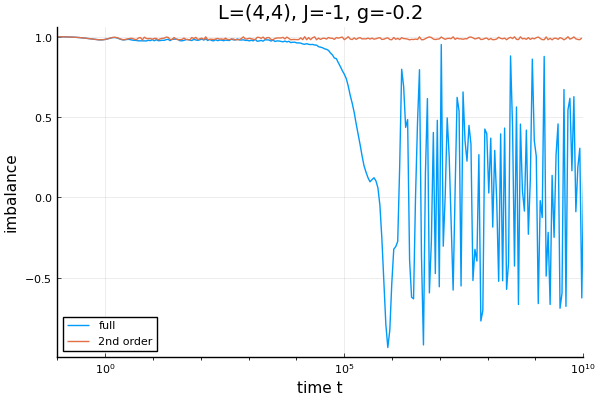

In [10]:
let
    dfE  = CSV.read("../data/obs_ED_n=3_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv",    DataFrame)

    plot(title = "L=($(L[1]),$(L[2])), J=$(J), g=$(g)", xlabel = "time t", ylabel = "imbalance",
                xlim = (0.1,1e10), xaxis = :log,
                # ylim = (-1,1),
                legend = :bottomleft,
            )

    plot!(dfE[:,"t"], dfE[:,"imb"], label="full")
    plot!(dataOrder[1][:,"t"], dataOrder[1][:,"imb"], label="2nd order")
end

In [ ]:
let 
    # nState = 476
    gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
    g = -0.5

    nState = 476
    H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
    V1 = sparse(H1+R1);
    V = V1
    EInit = -16.1

    f2Mod(x) = x - (H0[nState,nState] + BW_second_order_energyMod(nState, H0, V, x))
    f4Mod(x) = x - (H0[nState,nState] + BW_second_order_energyMod(nState, H0, V, x) + BW_fourth_order_energyMod(nState, H0, V, x))
    f2(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x))
    f4(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x))
    f6(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x))
    f8(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x) + BW_eighth_order_energy(nState, H0, V, x))


    # inds, vals = findnz(V[nState,:])
    # f(x) = x - 16 + mapreduce(+, zip(inds, vals)) do (i,v)
    #     nState == i && return 0
    #     DE = E-H0[i,i]
    #     return abs2(v)/DE
    # end
    @time res1 = find_zero(f4Mod, EInit) +16
    @time res2 = find_zero(f4, EInit) +16
    @show res1, res2
    #     return find_zero(f2, EInit) +16, find_zero(f4, EInit) +16, find_zero(f6, EInit) +16
    # end
    # @show data


    # p = scatter(abs.(gs),[0.0400, 0.161, 0.364, 0.651, 1.03], label = "data", legend = :topleft, 
    #     title = "scaling of energy difference", xlabel = "g", ylabel = L"\Delta E", markersize=5)

    # scatter!(abs.(gs), [abs(d[1]) for d in data], label = "second order")
    # scatter!(abs.(gs), [abs(d[2]) for d in data], label = "fourth order")
    # scatter!(abs.(gs), [abs(d[3]) for d in data], label = "sixth order")
    # plot(p)
end

calcTime normal = [0.006s, 0.06s, 17s, >72min]
calcTime matrix = [0.27s, 5s, 30s, 6min]

In [ ]:
# nState = 476
gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
g = -0.5

# E = -16.1
# g = -0.5
# H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
# V1 = sparse(H1+R1);
# V = V1

# inds1, vals1 = findnz(V[nState,:])
# return mapreduce(+, zip(inds1, vals1)) do (k1,v1)
#     nState == k1 && return 0
#     DE1 = E - H0[k1,k1]

#     inds2, vals2 = findnz(V[k1,:])
#     return mapreduce(+, zip(inds2, vals2)) do (k2,v2)
#         nState == k2 && return 0
#         DE2 = E - H0[k2,k2]

#         inds3, vals3 = findnz(V[k2,:])
#         return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
#             nState == k3 && return 0
#             DE3 = E - H0[k3,k3]

#             return v3*v2*v1*V[nState,k3]/(DE1*DE2*DE3)
#         end
#     end
# end

dataInds = map(init_states_indices) do nState
    g = -0.5
    H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
    V1 = sparse(H1+R1);
    V = V1
    EInit = -16.1

    f2(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x))
    f4(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x))
    f6(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x))
    f8(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x) + BW_eighth_order_energy(nState, H0, V, x))

    return find_zero(f2, EInit) +16, find_zero(f4, EInit) +16, find_zero(f6, EInit) +16
end

In [ ]:
dataInds8 = map(init_states_indices) do nState
    g = -0.5
    H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
    V1 = sparse(H1+R1);
    V = V1
    EInit = -16.1

    f2(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x))
    f4(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x))
    f6(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x))
    f8(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x) + BW_eighth_order_energy(nState, H0, V, x))

    return find_zero(f8, EInit) +16
end

In [ ]:
p = plot(legend = :topleft, title = "energy difference")

scatter!([abs(d[1]) for d in dataInds], label = "second order")
scatter!([abs(d[2]) for d in dataInds], label = "fourth order")
scatter!([abs(d[3]) for d in dataInds], label = "sixth order")
plot(p)

In [ ]:
let 
    nState = 476
    g = -0.5

    H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
    V1 = sparse(H1+R1);
    V = V1

    f2(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x))
    f4(x) = BW_fourth_order_energy(nState, H0, V, x)
    f6(x) = BW_sixth_order_energy(nState, H0, V, x)
    f8(x) = BW_eighth_order_energy(nState, H0, V, x)

    x = -17:0.1:-15

    data2 = f2.(x)
    data4 = data2 .- f4.(x) 
    data6 = data4 .- f6.(x) 


    plot()
    plot!(x, data2, label = "second order")
    plot!(x, data4, label = "fourth order")
    plot!(x, data6, label = "sixth order")
    # plot!(x, f8.(x), label = "eighth order")
end

### Rayleigh–Schrödinger

#### non-degenerate

In [ ]:
gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
orderData = map(gs) do g
    L= (4,4)
    N = prod(L);
    J = -1;
    #g = -0.1
    h = -0.

    next_neighbours = nearest_neighbours(L, collect(1:prod(L)))

    spin_basis = vec(collect(Iterators.product(fill([1,0],N)...)));
    dw_precalc = map(spin_basis) do spin
        return domainWallL(spin, L)
    end

    ### sort basis according to domain wall length ###
    sorted_spin_basis = sort(collect(zip(dw_precalc, spin_basis)), by = x->x[1])
    dw_precalc  = [d[1] for d in sorted_spin_basis]
    spin_basis  = [d[2] for d in sorted_spin_basis];

    spin_basis_table = Dict(
        map(enumerate(zip(spin_basis,dw_precalc))) do (i, (spin, dw))
            return (spin, (i,dw))
        end
    );

    domainWall_table = Dict(
        map(enumerate(dw_precalc)) do (i,  dw)
            return (i, dw)
        end
    );

    ### initial state ###
    init_spin = vcat(fill(1,Int(N/2)),fill(0,Int(N/2)))
    init_idx = first(spin_basis_table[Tuple(init_spin)])

    init_states_indices = [145,205,251,285,336,370,416,476]


    # psi=zeros(length(spin_basis))
    # psi[init_idx]=1
    # psi = sparse(psi)

    # ### build Hamiltonians ###
    H0  = build_H0(spin_basis, next_neighbours, spin_basis_table, (L,J,g,h));
    # H1,R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
    # @show R1[476,99:522]
    #display(toSpinMatr(spin_basis[99]))
    #display(toSpinMatr(spin_basis[100]))
    # for (r,c,v) in zip(findnz(H1[99:522,99:522])...)
    #     println(r,c,v)
    # end

    V1 = build_V1(spin_basis, spin_basis_table, (L,J,g,h));

    V = V1
    index = 476

    # inds, vals = findnz(V[nState,:])
    # return mapreduce(.+, zip(inds, vals)) do (i,v)
    #     # (H0[nState,nState] == H0[i,i]) && return 0
    #     return abs2(v)/(H0[nState,nState]-H0[i,i]), abs2(v)/(H0[nState,nState]-H0[i,i])^2
    # end

    res = map(init_states_indices) do index
        return (second_order_energy(index, H0, V1), fourth_order_energy(index, H0, V1), )# sixth_order_energy(index, H0, V1), )#eighth_order_energy(index, H0, V1))
    end

    return res
end

#### degenerate

In [ ]:
include("../src/SW.jl")
init_states_indices = [145,205,251,285,336,370,416,476]
L= (4,4)
N = prod(L);
J = -1;
h = -0.

next_neighbours = nearest_neighbours(L, collect(1:prod(L)))

spin_basis = vec(collect(Iterators.product(fill([1,0],N)...)));

dw_precalc = map(spin_basis) do spin
    return domainWallL(spin, L)
end

### sort basis according to domain wall length ###
sorted_spin_basis = sort(collect(zip(dw_precalc, spin_basis)), by = x->x[1])

dw_precalc  = [d[1] for d in sorted_spin_basis];
spin_basis  = [d[2] for d in sorted_spin_basis];

spin_basis_reduced = spin_basis[99:522]

init_states = map(init_states_indices.-98) do index
    return spin_basis_reduced[index]
end

pol_precalc = map(spin_basis_reduced) do spin
    return mapreduce(+, spin) do s
        return 2*s-1
    end
end

sorted_spin_basis_reduced = sort(collect(zip(pol_precalc, spin_basis_reduced)), by = x->x[1], rev = true)

pol_precalc = [d[1] for d in sorted_spin_basis_reduced];
spin_basis_reduced  = [d[2] for d in sorted_spin_basis_reduced];

spin_basis[99:522] = spin_basis_reduced

spin_basis_table = Dict(
    map(enumerate(zip(spin_basis,dw_precalc))) do (i, (spin, dw))
        return (spin, (i,dw))
    end
)

H0  = build_H0(spin_basis, next_neighbours, spin_basis_table, (L,J,g,h));
VInit = build_V1(spin_basis, spin_basis_table, (L,J,1,h))


# Testing

In [ ]:
include("../src/SW.jl")
init_states_indices = [145,205,251,285,336,370,416,476]

L= (4,4)
N = prod(L);
J = -1;
g = -0.5
h = -0.

next_neighbours = nearest_neighbours(L, collect(1:prod(L)))

spin_basis = vec(collect(Iterators.product(fill([1,0],N)...)));
dw_precalc = map(spin_basis) do spin
    return domainWallL(spin, L)
end

### sort basis according to domain wall length ###
sorted_spin_basis = sort(collect(zip(dw_precalc, spin_basis)), by = x->x[1])
dw_precalc  = [d[1] for d in sorted_spin_basis]
spin_basis  = [d[2] for d in sorted_spin_basis];

spin_basis_table = Dict(
    map(enumerate(zip(spin_basis,dw_precalc))) do (i, (spin, dw))
        return (spin, (i,dw))
    end
)

H0  = build_H0(spin_basis, next_neighbours, spin_basis_table, (L,J,g,h));
H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,1,h));
V1 = sparse(H1+R1);
V2 = V1^2
V4 = V2^2
V8 = V4^2

# vals, vecs = eigen(Matrix(V1[99:522,99:522]))
# transf = sparse(Matrix(1.0I, 2^16, 2^16))
# transf[99:522,99:522] = vecs;

In [ ]:
ts1 = [6.6e-8, 3.5e-6, 2.6e-5, 3.6e-5, 4.3e-4];
ts2 = [2.2e-7, 1.2e-5, 9.2e-5, 1.9e-4, 8.7e-4];

In [ ]:
gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
ps = map(enumerate(gs)) do (i,g) 
    h5open("../data/vecs_vals_red_g=$(g).h5", "r") do file
        indices = read(file["is"])
        dw = read(file["dws"])
        occs = read(file["occs"])
        vals = read(file["vals"])
        
        inds = [i for (i,v) in filter(i -> i[2] ∈ collect(195:202), collect(enumerate(indices)))]
        data = sort(abs.(map(i->vals[i], inds) .+ 16 .- abs(mean(sum.(orderData[i])))))
        return data[1]-data[4], data[end]-data[4], data[1]-data[end]
    end
end

ps

In [ ]:
gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
ps = map(enumerate(gs)) do (i,g) 
    h5open("../data/vecs_vals_red_g=$(g).h5", "r") do file
        indices = read(file["is"])
        dw = read(file["dws"])
        occs = read(file["occs"])
        vals = read(file["vals"])
        
        inds = [i for (i,v) in filter(i -> i[2] ∈ collect(195:202), collect(enumerate(indices)))]
        data = sort(abs.(map(i->vals[i], inds) .+ 16 .- abs(mean(sum.(orderData[i])))))
        return scatter(data , legend = :none) #, yaxis = :log)
    end
end

plot(ps..., layout = (1,5), size = (1600,300), dpi = 300, legend = :none, title = "energy distribution")

In [ ]:
orderData[5]

In [ ]:
V2_red = map(Iterators.product(init_states_indices,init_states_indices)) do (i,j)
    return V2[i,j]
end
V4_red = map(Iterators.product(init_states_indices,init_states_indices)) do (i,j)
    return V4[i,j]
end
V8_red2 = map(Iterators.product(init_states_indices,init_states_indices)) do (i,j)
    i == j && return 0
    return V8[i,j]
end
V8_red = map(Iterators.product(init_states_indices,init_states_indices)) do (i,j)
    return V8[i,j]
end

In [ ]:
let
    p = plot(legend = :outerright)
    g = -0.2
    vals, vecs = eigen(Matrix(V8_red))
    vals2, vecs2 = eigen(Matrix(g^8*V8_red/4^7))
    # plot((vals .- maximum(vals)) ./ maximum(vals), label = "V8")
    # plot!(vals, label = "V8")
    plot!(vals2, label = "V82")
    # plot((vals .- maximum(vals)) ./ maximum(vals), label = "V8")
    # plot((vals2 .- maximum(vals2)) ./ maximum(vals2), label = "V8")
    #plot!(vals2 ./ maximum(vals2), label = "V8_2")
    plot(p)
end

In [ ]:
p = plot(legend = :outerright)
for i in 7:8
    vals, vecs = eigen(Matrix(V8_red))
    scatter!(vecs[:,i], label = "$(i)")
end
plot(p)

In [ ]:
let
    gs = abs.([-0.1,-0.2,-0.3,-0.4,-0.5])
    ts1 = [6.6e-8, 3.5e-6, 2.6e-5, 3.6e-5, 4.3e-4];
    ts2 = [2.2e-7, 1.2e-5, 9.2e-5, 1.9e-4, 8.7e-4];

    scatter(gs, ts1, 
        label="1", yaxis = :log, 
        # xaxis=:log, 
        legend = :topleft,
    )
    scatter!(gs, ts2, label="2")
    plot!(gs, 1e-1*gs.^2, label = "2")
    plot!(gs, 0.001gs.^4, label = "4")
    plot!(gs, 0.1gs.^6, label = "6")
    plot!(gs, 10gs.^8, label = "8")
    plot!(gs, 0.05gs.^6 + 0.0008gs.^4, label = "4+6")
end